# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 140000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (140000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(118907, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

84.93357142857143

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

Observation(s):

1. I have keep only those values whose HelpfulnessNumerator <= HelpfulnessDenominator.

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(118905, 10)


1    99869
0    19036
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_118904 = final['Text'].values[118904]
print(sent_118904)
print("="*50)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.
I love chai tea and this is definitely reminiscent of that. It's got a wonderful aroma and tastes good hot or cold. I'm definitely buying it again. It also reminds me of special home-made tea I had at a NYC Indian restaurant which was fabulous. Excellent tea. Well worth the price!
Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.<br />strongly recommend


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_118904 = re.sub(r"http\S+", "", sent_118904)

print(sent_0)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_118904, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.
I love chai tea and this is definitely reminiscent of that. It's got a wonderful aroma and tastes good hot or cold. I'm definitely buying it again. It also reminds me of special home-made tea I had at a NYC Indian restaurant which was fabulous. Excellent tea. Well worth the price!
Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.strongly recommend


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_118904 = decontracted(sent_118904)
print(sent_118904)
print("="*50)

Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.<br />strongly recommend


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_118904 = re.sub('[^A-Za-z0-9]+', ' ', sent_118904)
print(sent_118904)

Purchased this product at a local store in NY and my kids and i love it Its a quick easy meal You can put in a toaster oven on toast for 6 min and its ready to eat br strongly recommend


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

Observation(s):

1. Here we are having set of stopwords.
2. Here so many unused word in the stopwords.
3. stopwords are words which contain a dictionary of unused words.
4. If we are removing stopwordsthen our Bag of Words is much smaller and meaningful vector.

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 118905/118905 [01:12<00:00, 1650.98it/s]


In [23]:
preprocessed_reviews[118904]

'purchased product local store ny kids love quick easy meal put toaster oven toast min ready eat strongly recommend'

In [24]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=preprocessed_reviews
final['CleanedText']=final['CleanedText']
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (118905, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138687,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,1,1210809600,A classic,Get the movie or sound track and sing along wi...,get movie sound track sing along carol king gr...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,1,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...,summary young boy describes usefulness chicken...


Observation(s):

1. Here processed review can be seen in the CleanedText Column.
2. We will use it for future observation.
3. we are having 118905 matrix of features.

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
# printing some random reviews
sent_0 = final['Summary'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Summary'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Summary'].values[1500]
print(sent_1500)
print("="*50)

sent_118904 = final['Summary'].values[118904]
print(sent_118904)
print("="*50)

A classic
Wonderfully soothing tea
Awesome underlooked seasoning!
DELICIOUS


In [26]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_118904 = re.sub(r"http\S+", "", sent_118904)

print(sent_0)

A classic


In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_118904, 'lxml')
text = soup.get_text()
print(text)

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent_118904 = decontracted(sent_118904)
print(sent_118904)
print("="*50)

In [30]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

A classic


In [31]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_118904 = re.sub('[^A-Za-z0-9]+', ' ', sent_118904)
print(sent_118904)

DELICIOUS


In [32]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [33]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_Summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 118905/118905 [00:51<00:00, 2287.08it/s]


In [34]:
preprocessed_Summary = [118904]
print (preprocessed_Summary)

[118904]


# Time Based Splitting

In [175]:
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# Randomly selecting 20K datapoints

# We will collect different 20K rows without repetition from time_sorted_data dataframe
final_20 = time_sorted_data.take(np.random.permutation(len(final))[:100000])
print(final_20.shape)
final_20.head(3)

(100000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
131048,142298,B000LKXJW0,A6J9G9FRGFURG,Stedfast,0,0,1,1304899200,ADDICTING!,I am so glad I bought these in bulk. They are ...,glad bought bulk addicting especially justin n...
112519,122069,B005LNA5VK,A19582ARL8WQSA,Dusty56,0,2,1,1315440000,hempseed oil,"Other than the postal delay , the product arri...",postal delay product arrived intact hopefully ...
55516,60235,B000HQMLQS,A1HO6J5FLD39T3,L. Hinnrichs,2,2,1,1221782400,My Favorite!!!,absolutely my favorite tea...has benefits of g...,absolutely favorite tea benefits green nice da...


Observation(s):
1. Time based splitting is better than random splitting.
2. In time based splitting we sort our data in ascending order.
3. In TIme based splitting we get better accuracy than random splitting.

In [176]:
# sample dataset 
final_20['Score'].value_counts()

1    83938
0    16062
Name: Score, dtype: int64

In [177]:
# Original dataset
final['Score'].value_counts()

1    99869
0    19036
Name: Score, dtype: int64

In [178]:
# Ratio of positive reviews to negative reviews in Sample Dataset
len(final_20[final_20['Score'] == 1])/len(final_20[final_20['Score'] == 0])

5.225874735400324

In [179]:
# Ratio of positive reviews to negative reviews in Original Dataset
len(final[final['Score'] == 1])/len(final[final['Score'] == 0])

5.246322756881698

In [180]:
# final_20 datapoints which will use to train model
X = final_20['CleanedText'].values
print("shape of X:", X.shape)

shape of X: (100000,)


In [181]:
# class label
y = final_20['Score'].values
print("shape of y:", y.shape)

shape of y: (100000,)


In [182]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# Splitting the data set into training set and test set:
from sklearn.model_selection import train_test_split

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.33)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, X_cv.shape, Y_cv.shape)

(53600,) (53600,) (20000,) (20000,) (26400,) (26400,)


Observation(s):
    
1. I have split the dataset into training set and testing set.
2. Here 80% of the data used to train the model and 20% of the data used to test its performance of the test set.
3. Here i have 53600 points to train the model and 20000 points to test its performance on the test set.

# [4] Featurization

## [4.1] BAG OF WORDS

In [183]:
#BoW
#https://www.kaggle.com/rochachan/part-1-for-beginners-bag-of-words
from sklearn.feature_extraction.text import CountVectorizer    #in scikit-learn
count_vect = CountVectorizer(min_df = 20, max_features=500).fit(X_train) # Here I am fitting my CountVectorizer function  into X_train and Then transform into X_train and X_test. 
# we also use fit_transform method for training set. I am doind it for auc
# min_df = 20;min_df = 20, which will remove any words from our vocabulary that appear in fewer than five documents.
# https://towardsdatascience.com/scikit-learn-for-text-analysis-of-amazon-fine-food-reviews-ea3b232c2c1b
X_train_bow = count_vect.transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, Y_train.shape)
print(X_cv_bow.shape, Y_cv.shape)
print(X_test_bow.shape, Y_test.shape)
print("="*100)

print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
print("the type of count vectorizer :",type(X_train_bow))
print("the shape of out text BOW vectorizer : ",X_train_bow.get_shape())
print("the number of unique words :", X_train_bow.get_shape()[1])

After vectorizations
(53600, 500) (53600,)
(26400, 500) (26400,)
(20000, 500) (20000,)
some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'also', 'alternative']
the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (53600, 500)
the number of unique words : 500


## [4.2] Bi-Grams and n-Grams.

In [184]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=20, max_features=500).fit(X_train)
X_train_bow = count_vect.transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (53600, 500)
the number of unique words including both unigrams and bigrams  500


## [4.3] TF-IDF

In [185]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(min_df=50, max_features=500).fit(X_train)
X_train_tf_idf = tf_idf_vect.transform(X_train)
X_cv_tf_idf = tf_idf_vect.transform(X_cv)
X_test_tf_idf = tf_idf_vect.transform(X_test)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
print("the type of count vectorizer :",type(X_train_tf_idf))
print("the shape of out text TFIDF vectorizer : ",X_train_tf_idf.get_shape())
print("the number of unique words :", X_train_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'also', 'alternative']
the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (53600, 500)
the number of unique words : 500


In [186]:
print("the number of unique words :", X_test_tf_idf.get_shape()[1])

the number of unique words : 500


## [4.4] Word2Vec

## Preparing Reviews for gensim model

In [187]:
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

## Training w2v model

In [188]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [189]:
# Train our own Word2Vec model using our own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))
print('='*70)

[('fantastic', 0.8421356081962585), ('good', 0.8292676210403442), ('awesome', 0.8199837803840637), ('terrific', 0.7893168330192566), ('excellent', 0.774961531162262), ('amazing', 0.7508574724197388), ('wonderful', 0.7247334718704224), ('decent', 0.7162784934043884), ('perfect', 0.7153140306472778), ('nice', 0.68163001537323)]
[('greatest', 0.8076849579811096), ('nastiest', 0.7470593452453613), ('best', 0.7393656373023987), ('tastiest', 0.7004806399345398), ('hottest', 0.6783171892166138), ('disgusting', 0.6406464576721191), ('closest', 0.6376954317092896), ('horrible', 0.5988778471946716), ('awful', 0.5942123532295227), ('smoothest', 0.5740275382995605)]


In [190]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14085
sample words  ['rancid', 'upon', 'receipt', 'terrible', 'little', 'sugar', 'used', 'something', 'went', 'wrong', 'not', 'believe', 'anyone', 'would', 'see', 'final', 'product', 'cans', 'doctor', 'wanted', 'baby', 'iron', 'fortified', 'cereal', 'son', 'refused', 'eat', 'cereals', 'like', 'earth', 'best', 'gerber', 'etc', 'one', 'eats', 'made', 'spain', 'seems', 'high', 'quality', 'child', 'fussy', 'may', 'work', 'amazon', 'sell', 'variety', 'pack', 'right', 'order']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

## Algorithm: Avg W2V

#### [4.4.1.1] Avg W2v

In [191]:
from tqdm import tqdm
import numpy as np

### Converting Train data text

In [192]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 53600/53600 [02:50<00:00, 313.50it/s]


(53600, 50)
[ 0.36787193  0.13557832  0.54196942  0.10703074  0.3731175  -0.47101764
 -0.22327467 -1.09696807 -0.49383985 -0.25977186  0.08627188 -0.97546521
  0.24467331  0.29519703  0.06967601  0.53892424 -0.57882263  0.57175148
  0.06935329  0.14353615  0.26194584 -0.23111652  0.65966835  0.13135608
  0.08632215 -0.1149428   0.59833751  0.04616286 -0.65074414  0.42647297
 -0.08495873  0.34870962 -0.25957959  0.07806083  0.47586776  0.61301404
  0.25609761 -0.11914791  0.35021247  0.49332661  0.70070173 -0.41343422
  0.07954752  0.33288618  0.45488553 -0.31142152 -0.4388345  -0.59344927
  0.05134107 -1.15334077]


### Converting CV data text

In [193]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [194]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|███████████████████████████████████████████████████████████████████████████| 26400/26400 [01:12<00:00, 364.02it/s]


(26400, 50)
[-0.42560259  0.0914072   0.20233797 -0.24948571  0.1027562  -0.26632763
 -0.05061407 -1.28461955 -0.75104363  0.11199325 -0.54410631 -0.13411445
  1.11125588  0.36881413 -0.20643493  0.59280866  0.5721378  -0.69129317
  0.8496917  -0.09803467  0.27818489  0.48955192 -0.15194345  1.48024686
 -0.31403108  0.7802504  -0.48589038 -0.81607573  0.11682234  0.20209766
 -0.57253593  0.42715201 -0.52978573 -0.33237512  0.89101628 -0.33808374
 -0.8228075   0.5112295   0.96265211  1.2188781   0.22039615 -0.92759922
  0.265905   -0.23401151  0.59751283 -0.21556003 -1.25164721 -0.08696962
 -0.01732763 -0.15045581]


### Converting Test data text

In [195]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [196]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:54<00:00, 366.51it/s]


(20000, 50)
[-0.3182887   0.34771484  0.66875421 -0.37344724 -0.07727721 -0.06481597
  0.35809202  0.13017284 -0.89759075 -1.04539116  0.8820886   0.44362232
  0.29974486 -0.19632478 -0.5440848   1.94966031  0.35522954 -0.61556573
  1.12636021 -0.31480199 -0.21251823 -0.7911291   0.95612422  0.958869
  0.14500793  0.31624578 -0.43132577 -1.07914795 -0.30946255 -0.29965257
 -0.16541501  0.14936315 -0.0891987  -0.00945403 -0.49007376 -0.3698195
  0.03655955 -0.50548895 -0.32351455  0.2548313   0.19339361 -0.74682715
 -0.39941448  1.12108964  0.48205813 -0.18930304 -1.52080077  0.68682975
  0.19779963 -0.48909088]


#### [4.4.1.2] TFIDF weighted W2v

In [197]:
from tqdm import tqdm
import numpy as np

In [198]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

### Converting Train data text

In [199]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_fealist_of_sentance_traint.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

100%|████████████████████████████████████████████████████████████████████████████| 53600/53600 [33:47<00:00, 26.44it/s]


(53600, 50)
[ 0.26252132  0.09036847  0.44528195  0.08918901  0.45515835 -0.38743828
 -0.17637089 -0.87792827 -0.36821609 -0.25868741  0.21339561 -0.84018053
  0.24456379  0.30334252  0.0853838   0.52410352 -0.47551006  0.51727302
  0.0299786   0.14489294  0.17423944 -0.15196491  0.69546161  0.05519618
  0.073347   -0.12728742  0.61438277 -0.00620756 -0.64254027  0.48558274
 -0.22596207  0.31022457 -0.26756815 -0.14665194  0.42537035  0.55969791
  0.40356547 -0.12378755  0.2076823   0.69626547  0.70742559 -0.48443457
  0.05927956  0.41773326  0.27376636 -0.12047613 -0.34264282 -0.44692646
  0.17096753 -0.99262385]


In [200]:
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))

53600
50


### Converting CV data text

In [201]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [202]:
tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_fealist_of_sentance_traint.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])

100%|████████████████████████████████████████████████████████████████████████████| 26400/26400 [16:14<00:00, 27.08it/s]


(26400, 50)
[-0.55483023 -0.0820945   0.00483126 -0.22722564 -0.02197936 -0.20708257
 -0.06427093 -1.26537584 -0.87785768  0.39393485 -0.43011599 -0.03253947
  0.85874814  0.42971786 -0.31935733  0.45001058  0.65889643 -0.54536274
  0.74249365 -0.27756841  0.30224138  0.66716938 -0.45478679  1.53296763
 -0.28545189  0.83784057 -0.54992114 -0.88281212  0.19555162  0.21571316
 -0.4292886   0.41348153 -0.58620812 -0.34642047  1.01404254 -0.34558475
 -1.00108333  0.49402471  1.39222687  1.57389454  0.31454766 -1.11654537
  0.16192245 -0.49635522  0.9347137   0.01652155 -1.56962047  0.10273521
 -0.01521675  0.16633144]


### Converting Test data text

In [203]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [204]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_fealist_of_sentance_traint.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [13:03<00:00, 31.47it/s]


(20000, 50)
[-0.44147283  0.23808191  0.68531117 -0.18988773  0.06842134  0.06952814
  0.37685636  0.2747041  -0.83554029 -1.34543019  0.97305417  0.59041306
  0.3263951  -0.22483248 -0.49038327  2.00208218  0.37035907 -0.88106544
  1.18754119 -0.2078116  -0.24904891 -1.08291025  0.93863073  0.93666435
  0.33729628  0.16342757 -0.47013833 -1.18176443 -0.44315988 -0.39147526
 -0.22991943  0.10926234 -0.19930166  0.19974226 -0.60132794 -0.50541701
  0.09555422 -0.63880949 -0.46199945  0.14528588  0.10647813 -0.75599974
 -0.26541354  1.08513715  0.46646914 -0.05061387 -1.49488182  0.83264591
  0.28894918 -0.46965582]


# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [205]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_bow_standardized = sc.fit_transform(X_train_bow)
X_test_bow_standardized = sc.transform(X_test_bow)
X_cv_bow_standardized = sc.transform(X_cv_bow)

In [206]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# tuned_parameters = [{'Depths': [[1, 5, 10, 50, 100, 500, 1000]]}]
# or we can wright it as
Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
base_learners  = [5, 10, 50, 100, 200, 500, 1000]

param_grid = {'max_depth':Depths, 'n_estimators':base_learners}

#Using GridSearchCV
model = GridSearchCV(RandomForestClassifier(class_weight = "balanced"), param_grid, scoring = 'roc_auc', cv=5, n_jobs=-1, 
                     pre_dispatch=2)
model.fit(X_cv_bow_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_cv_bow_standardized, Y_cv))

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of depth is : ",optimal_depth)
# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)
RF_bow_depth = optimal_depth
RF_bow_n_estimators = optimal_learners

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Accuracy of the model :  0.9109739811662756
The optimal value of depth is :  10
The optimal number of base learners is :  1000


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter useing seaborne heatmap

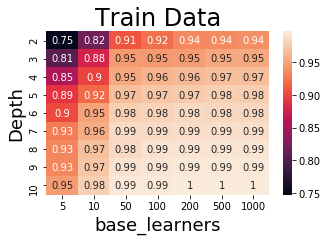

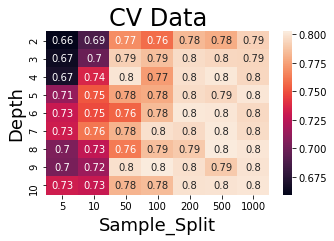

In [131]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
base_learners  = [5, 10, 50, 100, 200, 500, 1000]
hyperparameters = {'max_depth':Depths, 'n_estimators':base_learners}
for i in hyperparameters:

    RF = RandomForestClassifier(class_weight = "balanced", max_depth = i, n_estimators = i)
    Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    base_learners  = [5, 10, 50, 100, 200, 500, 1000]

    param_grid = {'max_depth':Depths, 'n_estimators':base_learners}
    clf = GridSearchCV(RF, param_grid, cv=5, scoring='roc_auc')
    clf.fit(X_train_bow_standardized, Y_train)


    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

df_heatmap = pd. DataFrame(train_auc. reshape(9, 7), index=Depths, columns=base_learners)
fig = plt. figure(figsize=(5, 3))
heatmap = sns. heatmap(df_heatmap, annot=True)
plt. xlabel('base_learners' , size=18)
plt. ylabel('Depth' , size=18)
plt. title("Train Data", size=24)
plt. show()

df_heatmap = pd. DataFrame(cv_auc. reshape(9, 7), index=Depths, columns=base_learners)
fig = plt. figure(figsize=(5, 3))
heatmap = sns. heatmap(df_heatmap, annot=True)
plt. xlabel('Sample_Split' , size=18)
plt. ylabel('Depth' , size=18)
plt. title("CV Data", size=24)
plt. show()

# Testing with Test data

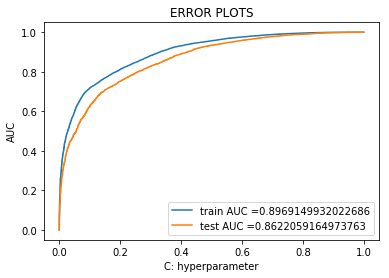

Train confusion matrix
[[ 6814  1735]
 [ 8364 36687]]
Test confusion matrix
[[ 2404   900]
 [ 3210 13486]]
Test AUC is: 0.8622059164973763


In [277]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


RF = RandomForestClassifier(class_weight = "balanced", max_depth = 10, n_estimators = 1000) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
RF.fit(X_train_bow_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, RF.predict_proba(X_train_bow_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, RF.predict_proba(X_test_bow_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, RF.predict(X_train_bow_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, RF.predict(X_test_bow_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
RF_bow_auc = roc_auc_score(Y_test, RF.predict_proba(X_test_bow_standardized)[:,1])
print("Test AUC is:", RF_bow_auc)

# Confusion Matrix of Training Set Of BOW Model

In [278]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_train, RF.predict(X_train_bow_standardized)))
cm

array([[ 6814,  1735],
       [ 8364, 36687]], dtype=int64)

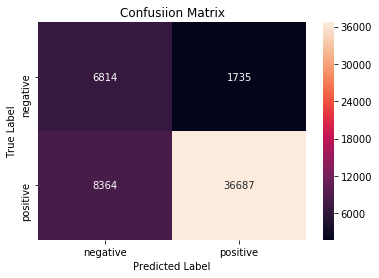

In [279]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of BOW Model.
1. As we have seen on confusion matrix, we have 36687 + 6814 = 43501 correct prediction on training set.
2. Acccuracy of 43501 correct prediction on training set is 81.158%.

# Confusion Matrix For Test Set Of BOW Model

In [280]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, RF.predict(X_test_bow_standardized)))
cm

array([[ 2404,   900],
       [ 3210, 13486]], dtype=int64)

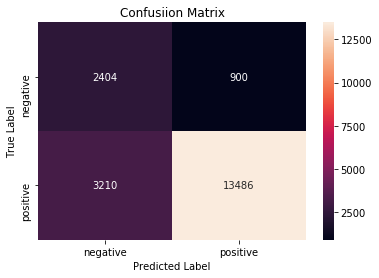

In [281]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of BOW Model.
2. As we have seen on confusion matrix, we have 13486 + 2404 = 15890 correct prediction on test set.
2. we have 15890 correct prediction on test set.

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

#### Top 20 important features of positive class from<font color='red'> SET 1</font>



Top 10 Important Features and their log probabilities For Positive Class :




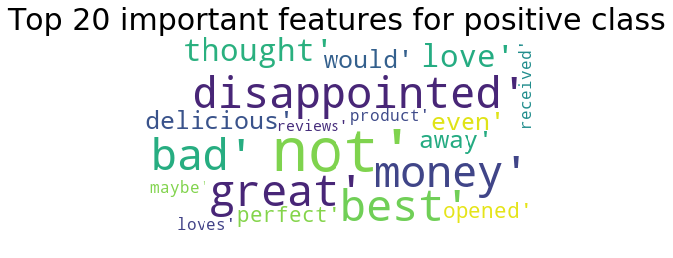

In [214]:
# Now we can find log probabilities of different features for 'positive' classes
RF_optimal = RandomForestClassifier(max_depth = optimal_depth, n_estimators = optimal_learners)
RF_optimal.fit(X_train_bow_standardized, Y_train)


class_features = RF_optimal.feature_importances_   # https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features
                                               # coef_ value is proportional to feature_log_prob_
                                               # It is like feature importance. This will give us festure importance
# 'positive' class
feature_names = pd.DataFrame(class_features.T,columns=['+ve'])

# Getting all feature names
feature_names['feature'] = count_vect.get_feature_names()

# Sorting 'positive_features' in descending order
sorted_positive_features = feature_names.sort_values(by = '+ve',kind = 'quicksort',ascending= False)
    
print("\n\nTop 10 Important Features and their log probabilities For Positive Class :\n\n")
np.array(sorted_positive_features['feature'][:20])
Positive_features = sorted_positive_features['feature'][:20]


# https://www.geeksforgeeks.org/generating-word-cloud-python/
# https://stackoverflow.com/questions/41792471/installing-wordcloud-using-jupyter-notebook
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# To install wordcloud >>>> conda install -c conda-forge wordcloud 

from wordcloud import WordCloud
wordcloud = WordCloud(collocations=False, background_color ='white', 
                min_font_size = 10).generate(str(list(Positive_features)))
plt.figure(figsize = (6, 7), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Top 20 important features for positive class",size= 30,)
plt.show()

#### Top 20 important features of negative class from<font color='red'> SET 1</font>



Top 10 Important Features and their log probabilities For Negative Class :




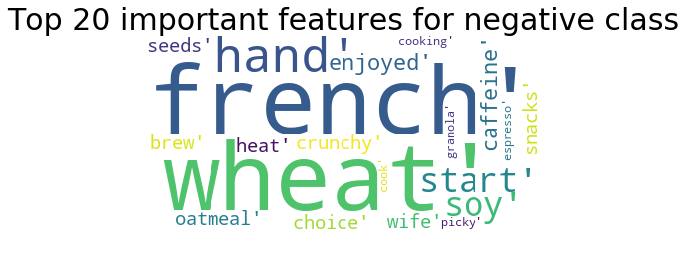

In [215]:
# Now we can find log probabilities of different features for 'negative' classes
class_features = RF_optimal.feature_importances_   # https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features
                                               # coef_ value is proportional to feature_log_prob_
                                               # It is like feature importance. This will give us festure importance
# 'positive' class
feature_names = pd.DataFrame(class_features.T,columns=['+ve'])

# Getting all feature names
feature_names['feature'] = count_vect.get_feature_names()

# Sorting 'positive_features' in descending order
sorted_positive_features = feature_names.sort_values(by = '+ve',kind = 'quicksort',ascending= False)
    
print("\n\nTop 10 Important Features and their log probabilities For Negative Class :\n\n")
np.array(sorted_positive_features.tail(20)['feature'])

Negative_features = sorted_positive_features.tail(20)['feature']


# https://www.geeksforgeeks.org/generating-word-cloud-python/
# https://stackoverflow.com/questions/41792471/installing-wordcloud-using-jupyter-notebook
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# To install wordcloud >>>> conda install -c conda-forge wordcloud 

from wordcloud import WordCloud
wordcloud = WordCloud(collocations=False, background_color ='white', 
                min_font_size = 10).generate(str(list(Negative_features)))
plt.figure(figsize = (6, 7), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Top 20 important features for negative class",size= 30,)
plt.show()

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [216]:
# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
X_train_tf_idf_standardized = sc.fit_transform(X_train_tf_idf)
X_cv_tf_idf_standardized = sc.fit_transform(X_cv_tf_idf)
X_test_tf_idf_standardized = sc.transform(X_test_tf_idf)

In [217]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# tuned_parameters = [{'Depths': [[1, 5, 10, 50, 100, 500, 1000]]}]
# or we can wright it as
Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
base_learners  = [5, 10, 50, 100, 200, 500, 1000]

param_grid = {'max_depth':Depths, 'n_estimators':base_learners}

#Using GridSearchCV
model = GridSearchCV(RandomForestClassifier(class_weight = "balanced"), param_grid, scoring = 'roc_auc', cv=5, n_jobs=-1, 
                     pre_dispatch=2)
model.fit(X_cv_tf_idf_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_cv_tf_idf_standardized, Y_cv))

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of depth is : ",optimal_depth)
# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)
RF_tfidf_depth = optimal_depth
RF_tfidf_n_estimators = optimal_learners

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Accuracy of the model :  0.923924775035939
The optimal value of depth is :  10
The optimal number of base learners is :  1000


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter useing seaborne heatmap

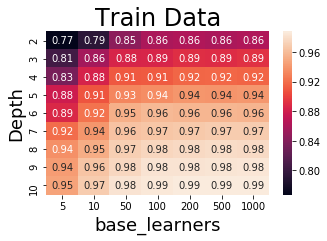

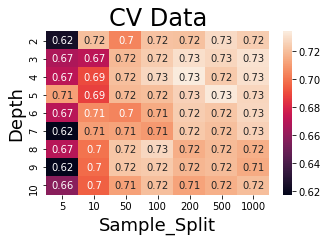

In [136]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
base_learners  = [5, 10, 50, 100, 200, 500, 1000]
hyperparameters = {'max_depth':Depths, 'n_estimators':base_learners}
for i in hyperparameters:

    RF = RandomForestClassifier(class_weight = "balanced", max_depth = i, n_estimators = i)
    Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    base_learners  = [5, 10, 50, 100, 200, 500, 1000]

    param_grid = {'max_depth':Depths, 'n_estimators':base_learners}
    clf = GridSearchCV(RF, param_grid, cv=5, scoring='roc_auc')
    clf.fit(X_train_tf_idf_standardized, Y_train)


    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

df_heatmap = pd. DataFrame(train_auc. reshape(9, 7), index=Depths, columns=base_learners)
fig = plt. figure(figsize=(5, 3))
heatmap = sns. heatmap(df_heatmap, annot=True)
plt. xlabel('base_learners' , size=18)
plt. ylabel('Depth' , size=18)
plt. title("Train Data", size=24)
plt. show()

df_heatmap = pd. DataFrame(cv_auc. reshape(9, 7), index=Depths, columns=base_learners)
fig = plt. figure(figsize=(5, 3))
heatmap = sns. heatmap(df_heatmap, annot=True)
plt. xlabel('Sample_Split' , size=18)
plt. ylabel('Depth' , size=18)
plt. title("CV Data", size=24)
plt. show()

# Testing with Test data

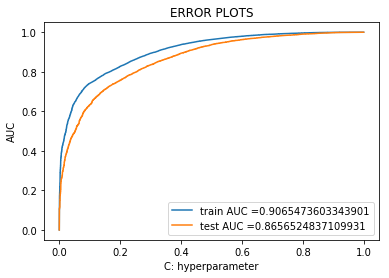

Train confusion matrix
[[ 6924  1625]
 [ 8168 36883]]
Test confusion matrix
[[ 2427   877]
 [ 3165 13531]]
Test AUC is: 0.8656524837109931


In [282]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


RF = RandomForestClassifier(class_weight = "balanced", max_depth = 10, n_estimators = 1000) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
RF.fit(X_train_tf_idf_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, RF.predict_proba(X_train_tf_idf_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, RF.predict_proba(X_test_tf_idf_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, RF.predict(X_train_tf_idf_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, RF.predict(X_test_tf_idf_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
RF_tfidf_auc = roc_auc_score(Y_test, RF.predict_proba(X_test_tf_idf_standardized)[:,1])
print("Test AUC is:", RF_tfidf_auc)

In [284]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== RF with depth = optimal_depth and  n_estimators = optimal_learners===============================================
# instantiate learning model depth = optimal_depth

RF_optimal = RandomForestClassifier(max_depth = optimal_depth, n_estimators = optimal_learners)

# fitting the model
RF_optimal.fit(X_train_tf_idf_standardized, Y_train)

# predict the response
Y_pred = RF_optimal.predict(X_test_tf_idf_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the RandomForestClassifier for depth = %d is %.3f%%' % (optimal_depth, acc))

print('\nThe Test Accuracy of the RandomForestClassifier for n_estimators = %d is %.3f%%' % (optimal_learners, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
RF_tfidf_depth = optimal_depth
RF_tfidf_n_estimators = optimal_learners
RF_tfidf_train_acc = model.score(X_test_tf_idf_standardized, Y_test)*100
RF_tfidf_test_acc = acc


The Test Accuracy of the RandomForestClassifier for depth = 7 is 83.480%

The Test Accuracy of the RandomForestClassifier for n_estimators = 1000 is 83.480%


Observation(s):

1. The Test Accuracy of the RandomForestClassifier for depth = 7 is 83.480%.

2. The Test Accuracy of the RandomForestClassifier for n_estimators = 1000 is 83.480%

# Confusion Matrix of Training Set Of TFIDF Model

In [285]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_train, RF.predict(X_train_tf_idf_standardized)))
cm

array([[ 6924,  1625],
       [ 8168, 36883]], dtype=int64)

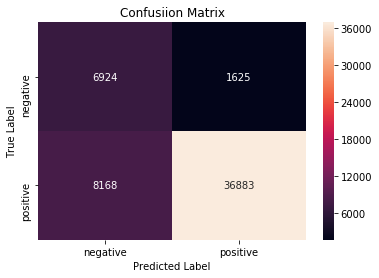

In [286]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of TFIDF Model.
1. As we have seen on confusion matrix, we have 36883 + 6924 = 43807 correct prediction on training set.
2. Acccuracy of 43807 correct prediction on training set is 81.729%.

# Confusion Matrix For Test Set Of TFIDF Model

In [287]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, RF.predict(X_test_tf_idf_standardized)))
cm

array([[ 2427,   877],
       [ 3165, 13531]], dtype=int64)

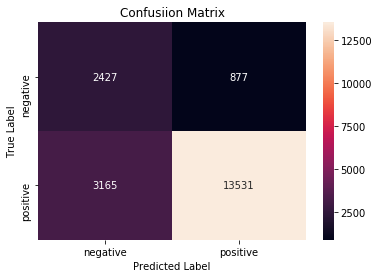

In [288]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of TFIDF Model.
2. As we have seen on confusion matrix, we have 13531 + 2427 = 15958 correct prediction on test set.
2. we have 15958 correct prediction on test set.

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

#### Top 20 important features of positive class from<font color='red'> SET 1</font>



Top 10 Important Features and their log probabilities For Positive Class :




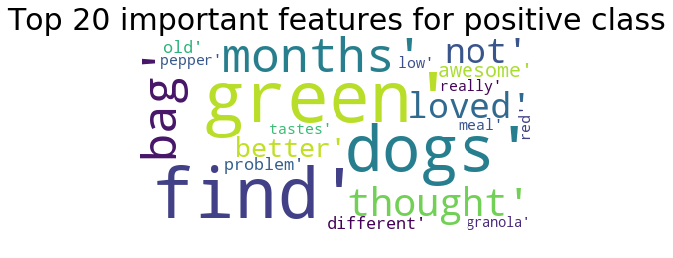

In [224]:
# Now we can find log probabilities of different features for 'positive' classes
class_features = RF_optimal.feature_importances_   # https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features
                                               # coef_ value is proportional to feature_log_prob_
                                               # It is like feature importance. This will give us festure importance
# 'positive' class
feature_names = pd.DataFrame(class_features.T,columns=['+ve'])

# Getting all feature names
feature_names['feature'] = count_vect.get_feature_names()

# Sorting 'positive_features' in descending order
sorted_positive_features = feature_names.sort_values(by = '+ve',kind = 'quicksort',ascending= False)
    
print("\n\nTop 10 Important Features and their log probabilities For Positive Class :\n\n")
np.array(sorted_positive_features['feature'][:20])
Positive_features = sorted_positive_features['feature'][:20]


# https://www.geeksforgeeks.org/generating-word-cloud-python/
# https://stackoverflow.com/questions/41792471/installing-wordcloud-using-jupyter-notebook
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# To install wordcloud >>>> conda install -c conda-forge wordcloud 

from wordcloud import WordCloud
wordcloud = WordCloud(collocations=False, background_color ='white', 
                min_font_size = 10).generate(str(list(Positive_features)))
plt.figure(figsize = (6, 7), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Top 20 important features for positive class",size= 30,)
plt.show()

#### Top 20 important features of negative class from<font color='red'> SET 1</font>



Top 10 Important Features and their log probabilities For Negative Class :




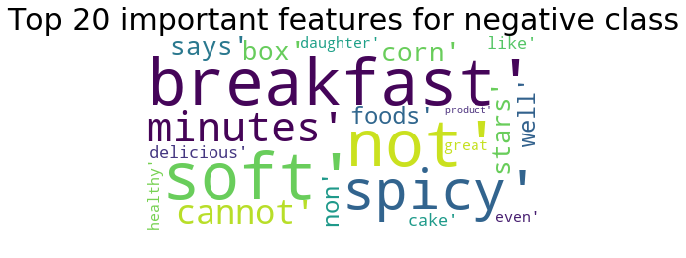

In [225]:
# Now we can find log probabilities of different features for 'positive' classes
class_features = RF_optimal.feature_importances_   # https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features
                                               # coef_ value is proportional to feature_log_prob_
                                               # It is like feature importance. This will give us festure importance
# 'positive' class
feature_names = pd.DataFrame(class_features.T,columns=['+ve'])

# Getting all feature names
feature_names['feature'] = count_vect.get_feature_names()

# Sorting 'positive_features' in descending order
sorted_positive_features = feature_names.sort_values(by = '+ve',kind = 'quicksort',ascending= False)
    
print("\n\nTop 10 Important Features and their log probabilities For Negative Class :\n\n")
np.array(sorted_positive_features.tail(20)['feature'])

Negative_features = sorted_positive_features.tail(20)['feature']


# https://www.geeksforgeeks.org/generating-word-cloud-python/
# https://stackoverflow.com/questions/41792471/installing-wordcloud-using-jupyter-notebook
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# To install wordcloud >>>> conda install -c conda-forge wordcloud 

from wordcloud import WordCloud
wordcloud = WordCloud(collocations=False, background_color ='white', 
                min_font_size = 10).generate(str(list(Negative_features)))
plt.figure(figsize = (6, 7), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Top 20 important features for negative class",size= 30,)
plt.show()

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [228]:
# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
sent_vectors_train_standardized = sc.fit_transform(sent_vectors_train)
sent_vectors_cv_standardized = sc.fit_transform(sent_vectors_cv)
sent_vectors_test_standardized = sc.transform(sent_vectors_test)

In [230]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# tuned_parameters = [{'Depths': [[1, 5, 10, 50, 100, 500, 1000]]}]
# or we can wright it as
Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
base_learners  = [5, 10, 50, 100, 200, 500, 1000]

param_grid = {'max_depth':Depths, 'n_estimators':base_learners}

#Using GridSearchCV
model = GridSearchCV(RandomForestClassifier(class_weight = "balanced"), param_grid, scoring = 'roc_auc', cv=5, n_jobs=-1, 
                     pre_dispatch=2)
model.fit(sent_vectors_cv_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(sent_vectors_cv_standardized, Y_cv))

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of depth is : ",optimal_depth)
# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)
RF_w2v_depth = optimal_depth
RF_w2v_n_estimators = optimal_learners

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Accuracy of the model :  0.9239332170466432
The optimal value of depth is :  7
The optimal number of base learners is :  1000


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter useing seaborne heatmap

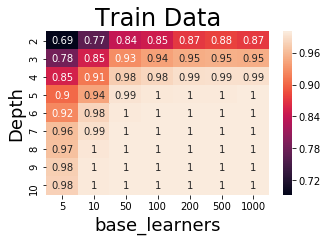

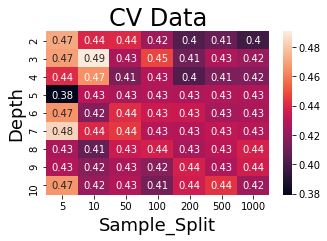

In [139]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
base_learners  = [5, 10, 50, 100, 200, 500, 1000]
hyperparameters = {'max_depth':Depths, 'n_estimators':base_learners}
for i in hyperparameters:

    RF = RandomForestClassifier(class_weight = "balanced", max_depth = i, n_estimators = i)
    Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    base_learners  = [5, 10, 50, 100, 200, 500, 1000]

    param_grid = {'max_depth':Depths, 'n_estimators':base_learners}
    clf = GridSearchCV(RF, param_grid, cv=5, scoring='roc_auc')
    clf.fit(sent_vectors_train_standardized, Y_train)


    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

df_heatmap = pd. DataFrame(train_auc. reshape(9, 7), index=Depths, columns=base_learners)
fig = plt. figure(figsize=(5, 3))
heatmap = sns. heatmap(df_heatmap, annot=True)
plt. xlabel('base_learners' , size=18)
plt. ylabel('Depth' , size=18)
plt. title("Train Data", size=24)
plt. show()

df_heatmap = pd. DataFrame(cv_auc. reshape(9, 7), index=Depths, columns=base_learners)
fig = plt. figure(figsize=(5, 3))
heatmap = sns. heatmap(df_heatmap, annot=True)
plt. xlabel('Sample_Split' , size=18)
plt. ylabel('Depth' , size=18)
plt. title("CV Data", size=24)
plt. show()

# Testing with Test data

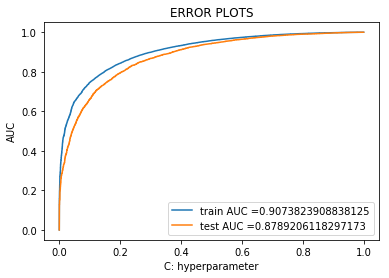

Train confusion matrix
[[ 7193  1356]
 [ 8524 36527]]
Test confusion matrix
[[ 2596   708]
 [ 3238 13458]]
Test AUC is: 0.8789206118297173


In [231]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


RF = RandomForestClassifier(class_weight = "balanced", max_depth = 7, n_estimators = 1000) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
RF.fit(sent_vectors_train_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, RF.predict_proba(sent_vectors_train_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, RF.predict_proba(sent_vectors_test_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, RF.predict(sent_vectors_train_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, RF.predict(sent_vectors_test_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
RF_avg_w2v_auc = roc_auc_score(Y_test, RF.predict_proba(sent_vectors_test_standardized)[:,1])
print("Test AUC is:", RF_avg_w2v_auc)

In [232]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== RF with depth = optimal_depth and  n_estimators = optimal_learners===============================================
# instantiate learning model max_depth = optimal_depth

RF_optimal = RandomForestClassifier(max_depth = optimal_depth, n_estimators = optimal_learners)

# fitting the model
RF_optimal.fit(sent_vectors_train_standardized, Y_train)

# predict the response
Y_pred = RF_optimal.predict(sent_vectors_test_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the RandomForestClassifier for depth = %d is %.3f%%' % (optimal_depth, acc))

print('\nThe Test Accuracy of the RandomForestClassifier for n_estimators = %d is %.3f%%' % (optimal_learners, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
RF_avg_w2v_depth = optimal_depth
RF_avg_w2v_n_estimators = optimal_learners
RF_avg_w2v_train_acc = model.score(sent_vectors_test_standardized, Y_test)*100
RF_avg_w2v_test_acc = acc


The Test Accuracy of the RandomForestClassifier for depth = 7 is 85.420%

The Test Accuracy of the RandomForestClassifier for n_estimators = 1000 is 85.420%


Observation(s):

1. The Test Accuracy of the RandomForestClassifier for depth = 7 is 85.420%.

2. The Test Accuracy of the RandomForestClassifier for n_estimators = 1000 is 85.420%.

# Confusion Matrix of Training Set Of w2v Model

In [233]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_train, RF.predict(sent_vectors_train_standardized)))
cm

array([[ 7193,  1356],
       [ 8524, 36527]], dtype=int64)

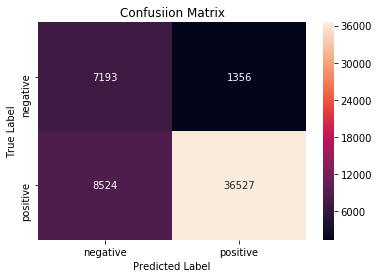

In [234]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of AVG W2V Model.
1. As we have seen on confusion matrix, we have 36527 + 7193 = 43720 correct prediction on training set.
2. Acccuracy of 43720 correct prediction on training set is 81.567%.

# Confusion Matrix For Test Set Of w2v Model

In [235]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, RF.predict(sent_vectors_test_standardized)))
cm

array([[ 2596,   708],
       [ 3238, 13458]], dtype=int64)

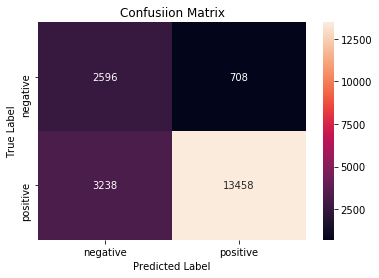

In [236]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of AVG W2V Model.
2. As we have seen on confusion matrix, we have 13458 + 2596 = 16054 correct prediction on test set.
2. we have 16054 correct prediction on test set.

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [237]:
# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
tfidf_sent_vectors_train_standardized = sc.fit_transform(tfidf_sent_vectors_train)
tfidf_sent_vectors_cv_standardized = sc.fit_transform(tfidf_sent_vectors_cv)
tfidf_sent_vectors_test_standardized = sc.transform(tfidf_sent_vectors_test)

In [239]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# tuned_parameters = [{'Depths': [[1, 5, 10, 50, 100, 500, 1000]]}]
# or we can wright it as
Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
base_learners  = [5, 10, 50, 100, 200, 500, 1000]

param_grid = {'max_depth':Depths, 'n_estimators':base_learners}

#Using GridSearchCV
model = GridSearchCV(RandomForestClassifier(class_weight = "balanced"), param_grid, scoring = 'roc_auc', cv=5, n_jobs=-1, 
                     pre_dispatch=2)
model.fit(tfidf_sent_vectors_cv_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(tfidf_sent_vectors_cv_standardized, Y_cv))

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of depth is : ",optimal_depth)
# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)
RF_tfidf_w2v_depth = optimal_depth
RF_tfidf_w2v_n_estimators = optimal_learners

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Accuracy of the model :  0.9745872940790435
The optimal value of depth is :  10
The optimal number of base learners is :  1000


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter useing seaborne heatmap

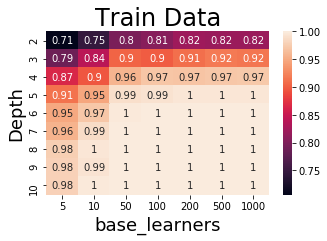

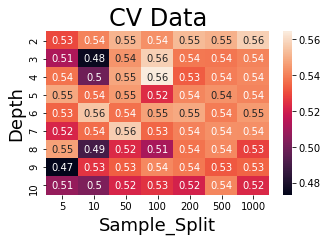

In [142]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
base_learners  = [5, 10, 50, 100, 200, 500, 1000]
hyperparameters = {'max_depth':Depths, 'n_estimators':base_learners}
for i in hyperparameters:

    RF = RandomForestClassifier(class_weight = "balanced", max_depth = i, n_estimators = i)
    Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    base_learners  = [5, 10, 50, 100, 200, 500, 1000]

    param_grid = {'max_depth':Depths, 'n_estimators':base_learners}
    clf = GridSearchCV(RF, param_grid, cv=5, scoring='roc_auc')
    clf.fit(tfidf_sent_vectors_train_standardized, Y_train)


    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

df_heatmap = pd. DataFrame(train_auc. reshape(9, 7), index=Depths, columns=base_learners)
fig = plt. figure(figsize=(5, 3))
heatmap = sns. heatmap(df_heatmap, annot=True)
plt. xlabel('base_learners' , size=18)
plt. ylabel('Depth' , size=18)
plt. title("Train Data", size=24)
plt. show()

df_heatmap = pd. DataFrame(cv_auc. reshape(9, 7), index=Depths, columns=base_learners)
fig = plt. figure(figsize=(5, 3))
heatmap = sns. heatmap(df_heatmap, annot=True)
plt. xlabel('Sample_Split' , size=18)
plt. ylabel('Depth' , size=18)
plt. title("CV Data", size=24)
plt. show()

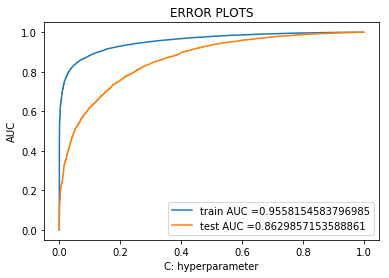

Train confusion matrix
[[ 7608   941]
 [ 4965 40086]]
Test confusion matrix
[[ 2141  1163]
 [ 2168 14528]]
Test AUC is: 0.8629857153588861


In [240]:
# Testing with Test data
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


RF = RandomForestClassifier(class_weight = "balanced", max_depth = 10, n_estimators = 1000) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
RF.fit(tfidf_sent_vectors_train_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, RF.predict_proba(tfidf_sent_vectors_train_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, RF.predict_proba(tfidf_sent_vectors_test_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, RF.predict(tfidf_sent_vectors_train_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, RF.predict(tfidf_sent_vectors_test_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
RF_tfidf_w2v_auc = roc_auc_score(Y_test, RF.predict_proba(tfidf_sent_vectors_test_standardized)[:,1])
print("Test AUC is:", RF_tfidf_w2v_auc)

In [241]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== RF with depth = optimal_depth and  n_estimators = optimal_learners===============================================
# instantiate learning model depth = optimal_depth

RF_optimal = RandomForestClassifier(max_depth = optimal_depth, n_estimators = optimal_learners)

# fitting the model
RF_optimal.fit(tfidf_sent_vectors_train_standardized, Y_train)

# predict the response
Y_pred = RF_optimal.predict(tfidf_sent_vectors_test_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the RandomForestClassifier for depth = %d is %.3f%%' % (optimal_depth, acc))

print('\nThe Test Accuracy of the RandomForestClassifier for n_estimators = %d is %.3f%%' % (optimal_learners, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
RF_tfidf_w2v_depth = optimal_depth
RF_tfidf_w2v_n_estimators = optimal_learners
RF_tfidf_w2v_train_acc = model.score(tfidf_sent_vectors_test_standardized, Y_test)*100
RF_tfidf_w2v_test_acc = acc


The Test Accuracy of the RandomForestClassifier for depth = 10 is 85.575%

The Test Accuracy of the RandomForestClassifier for n_estimators = 1000 is 85.575%


Observation(s):

1. The Test Accuracy of the RandomForestClassifier for depth = 10 is 85.575%.

2. The Test Accuracy of the RandomForestClassifier for n_estimators = 1000 is 85.575%.

# Confusion Matrix of Training Set Of TFIDF W2V Model

In [242]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_train, RF.predict(tfidf_sent_vectors_train_standardized)))
cm

array([[ 7608,   941],
       [ 4965, 40086]], dtype=int64)

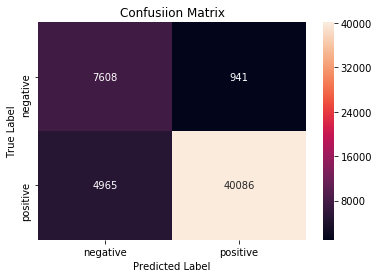

In [243]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of TFIDF W2V Model.
1. As we have seen on confusion matrix, we have 40086 + 7608 = 47694 correct prediction on training set.
2. Acccuracy of 47694 correct prediction on training set is 88.981%.

# Confusion Matrix For Test Set Of TFIDF W2V Model

In [244]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, RF.predict(sent_vectors_test_standardized)))
cm

array([[ 2424,   880],
       [ 2460, 14236]], dtype=int64)

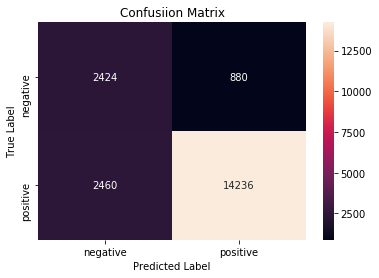

In [245]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of TFIDF W2V Model.
2. As we have seen on confusion matrix, we have 14236 + 2424 = 16660 correct prediction on test set.
2. we have 16660 correct prediction on test set.

## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [246]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_bow_standardized = sc.fit_transform(X_train_bow)
X_test_bow_standardized = sc.transform(X_test_bow)
X_cv_bow_standardized = sc.transform(X_cv_bow)

In [248]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
import xgboost as xgb
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# tuned_parameters = [{'Depths': [[1,3,5,7,70,100,500]]}]
# or we can wright it as
Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
base_learners  = [5, 10, 50, 100, 200, 500, 1000]

param_grid = {'max_depth':Depths, 'n_estimators':base_learners}

#Using GridSearchCV
model = GridSearchCV(xgb.XGBClassifier(class_weight = "balanced"), param_grid, scoring = 'roc_auc', cv=5, n_jobs=-1, 
                     pre_dispatch=2)
model.fit(X_cv_bow_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_cv_bow_standardized, Y_cv))

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of depth is : ",optimal_depth)
# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)
XGB_bow_depth = optimal_depth
XGB_bow_n_estimators = optimal_learners

Model with best parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
Accuracy of the model :  0.9633861751812616
The optimal value of depth is :  3
The optimal number of base learners is :  1000


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter useing seaborne heatmap

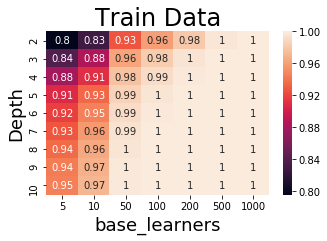

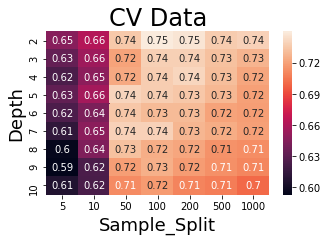

In [146]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
base_learners  = [5, 10, 50, 100, 200, 500, 1000]
hyperparameters = {'max_depth':Depths, 'n_estimators':base_learners}
for i in hyperparameters:

    XGB = xgb.XGBClassifier(class_weight = "balanced", max_depth = i, n_estimators = i)
    Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    base_learners  = [5, 10, 50, 100, 200, 500, 1000]

    param_grid = {'max_depth':Depths, 'n_estimators':base_learners}
    clf = GridSearchCV(XGB, param_grid, cv=5, scoring='roc_auc')
    clf.fit(X_train_bow_standardized, Y_train)


    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

df_heatmap = pd. DataFrame(train_auc. reshape(9, 7), index=Depths, columns=base_learners)
fig = plt. figure(figsize=(5, 3))
heatmap = sns. heatmap(df_heatmap, annot=True)
plt. xlabel('base_learners' , size=18)
plt. ylabel('Depth' , size=18)
plt. title("Train Data", size=24)
plt. show()

df_heatmap = pd. DataFrame(cv_auc. reshape(9, 7), index=Depths, columns=base_learners)
fig = plt. figure(figsize=(5, 3))
heatmap = sns. heatmap(df_heatmap, annot=True)
plt. xlabel('Sample_Split' , size=18)
plt. ylabel('Depth' , size=18)
plt. title("CV Data", size=24)
plt. show()

# Testing with Test data

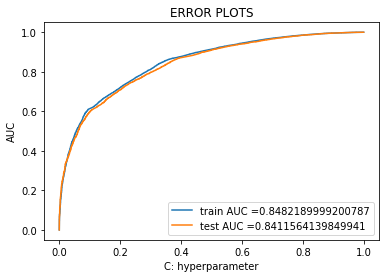

Train confusion matrix
[[ 6442  2107]
 [10574 34477]]
Test confusion matrix
[[ 2431   873]
 [ 3898 12798]]
Test AUC is: 0.8411564139849941


In [289]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


XGB = xgb.XGBClassifier(class_weight = "balanced", max_depth = 3, n_estimators = 1000) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
XGB.fit(X_train_bow_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, XGB.predict_proba(X_train_bow_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, XGB.predict_proba(X_test_bow_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, XGB.predict(X_train_bow_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, XGB.predict(X_test_bow_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
XGB_bow_auc = roc_auc_score(Y_test, XGB.predict_proba(X_test_bow_standardized)[:,1])
print("Test AUC is:", XGB_bow_auc)

# Confusion Matrix of Training Set Of BOW Model

In [294]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_train, XGB.predict(X_train_bow_standardized)))
cm

array([[ 6442,  2107],
       [10574, 34477]], dtype=int64)

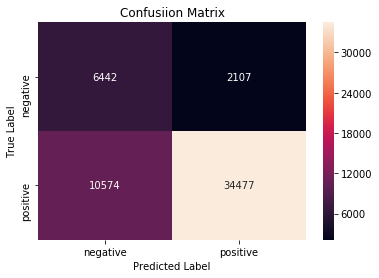

In [295]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of BOW Model.
1. As we have seen on confusion matrix, we have 34477 + 6442 = 40919 correct prediction on training set.
2. Acccuracy of 40640 correct prediction on training set is 76.341%.

# Confusion Matrix of Test Set Of BOW Model

In [296]:
# Confusion Matrix For Test Set Of BOW Model
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, XGB.predict(X_test_bow_standardized)))
cm

array([[ 2431,   873],
       [ 3898, 12798]], dtype=int64)

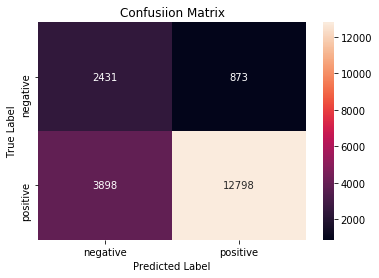

In [297]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of BOW Model.
2. As we have seen on confusion matrix, we have 12798 + 2431 = 15229 correct prediction on test set.
2. we have 15229 correct prediction on test set.

### Wordcloud of top 20 important features from<font color='red'> SET 2</font>

#### Top 20 important features of positive class from<font color='red'> SET 2</font>



Top 10 Important Features and their log probabilities For Positive Class :




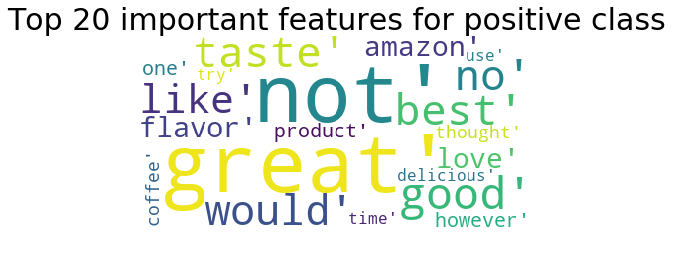

In [258]:
XGB_optimal = xgb.XGBClassifier(max_depth = optimal_depth, n_estimators = optimal_learners)

# fitting the model
XGB_optimal.fit(X_train_bow_standardized, Y_train)

# Now we can find log probabilities of different features for 'positive' classes
class_features = XGB_optimal.feature_importances_   # https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features
                                               # coef_ value is proportional to feature_log_prob_
                                               # It is like feature importance. This will give us festure importance
# 'positive' class
feature_names = pd.DataFrame(class_features.T,columns=['+ve'])

# Getting all feature names
feature_names['feature'] = count_vect.get_feature_names()

# Sorting 'positive_features' in descending order
sorted_positive_features = feature_names.sort_values(by = '+ve',kind = 'quicksort',ascending= False)
    
print("\n\nTop 10 Important Features and their log probabilities For Positive Class :\n\n")
np.array(sorted_positive_features['feature'][:20])
Positive_features = sorted_positive_features['feature'][:20]


# https://www.geeksforgeeks.org/generating-word-cloud-python/
# https://stackoverflow.com/questions/41792471/installing-wordcloud-using-jupyter-notebook
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# To install wordcloud >>>> conda install -c conda-forge wordcloud 

from wordcloud import WordCloud
wordcloud = WordCloud(collocations=False, background_color ='white', 
                min_font_size = 10).generate(str(list(Positive_features)))
plt.figure(figsize = (6, 7), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Top 20 important features for positive class",size= 30,)
plt.show()

#### Top 20 important features of negative class from<font color='red'> SET 2</font>



Top 10 Important Features and their log probabilities For Negative Class :




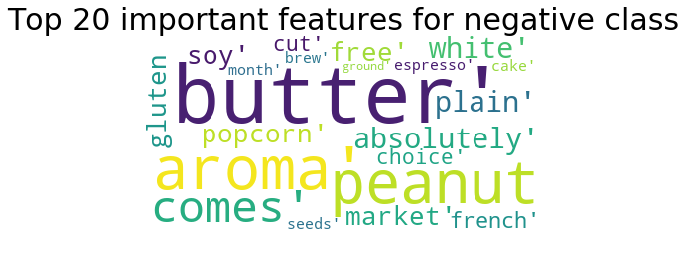

In [259]:
# Now we can find log probabilities of different features for 'negative' classes
class_features = XGB_optimal.feature_importances_   # https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features
                                               # coef_ value is proportional to feature_log_prob_
                                               # It is like feature importance. This will give us festure importance
# 'positive' class
feature_names = pd.DataFrame(class_features.T,columns=['+ve'])

# Getting all feature names
feature_names['feature'] = count_vect.get_feature_names()

# Sorting 'positive_features' in descending order
sorted_positive_features = feature_names.sort_values(by = '+ve',kind = 'quicksort',ascending= False)
    
print("\n\nTop 10 Important Features and their log probabilities For Negative Class :\n\n")
np.array(sorted_positive_features.tail(20)['feature'])

Negative_features = sorted_positive_features.tail(20)['feature']


# https://www.geeksforgeeks.org/generating-word-cloud-python/
# https://stackoverflow.com/questions/41792471/installing-wordcloud-using-jupyter-notebook
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# To install wordcloud >>>> conda install -c conda-forge wordcloud 

from wordcloud import WordCloud
wordcloud = WordCloud(collocations=False, background_color ='white', 
                min_font_size = 10).generate(str(list(Negative_features)))
plt.figure(figsize = (6, 7), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Top 20 important features for negative class",size= 30,)
plt.show()

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [261]:
# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
X_train_tf_idf_standardized = sc.fit_transform(X_train_tf_idf)
X_cv_tf_idf_standardized = sc.fit_transform(X_cv_tf_idf)
X_test_tf_idf_standardized = sc.transform(X_test_tf_idf)

In [262]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# tuned_parameters = [{'Depths': [[1,3,5,7,70,100,500]]}]
# or we can wright it as
Depths = [3, 4, 5, 6, 7, 8, 9, 10]
base_learners  = [5, 10, 50, 100, 200, 500, 1000]

param_grid = {'max_depth':Depths, 'n_estimators':base_learners}

#Using GridSearchCV
model = GridSearchCV(xgb.XGBClassifier(class_weight = "balanced"), param_grid, scoring = 'roc_auc', cv=5, n_jobs=-1, 
                     pre_dispatch=2)
model.fit(X_cv_tf_idf_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_cv_tf_idf_standardized, Y_cv))

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of depth is : ",optimal_depth)
# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)
XGB_tfidf_depth = optimal_depth
XGB_tfidf_n_estimators = optimal_learners

Model with best parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
Accuracy of the model :  0.975979556694119
The optimal value of depth is :  3
The optimal number of base learners is :  1000


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter useing seaborne heatmap

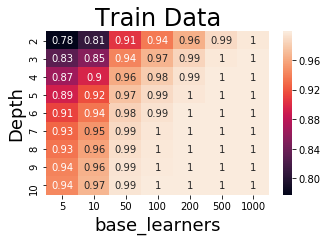

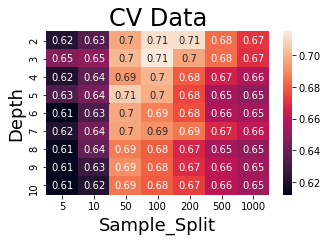

In [149]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
base_learners  = [5, 10, 50, 100, 200, 500, 1000]
hyperparameters = {'max_depth':Depths, 'n_estimators':base_learners}
for i in hyperparameters:

    XGB = xgb.XGBClassifier(class_weight = "balanced", max_depth = i, n_estimators = i)
    Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    base_learners  = [5, 10, 50, 100, 200, 500, 1000]

    param_grid = {'max_depth':Depths, 'n_estimators':base_learners}
    clf = GridSearchCV(XGB, param_grid, cv=5, scoring='roc_auc')
    clf.fit(X_train_tf_idf_standardized, Y_train)


    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

df_heatmap = pd. DataFrame(train_auc. reshape(9, 7), index=Depths, columns=base_learners)
fig = plt. figure(figsize=(5, 3))
heatmap = sns. heatmap(df_heatmap, annot=True)
plt. xlabel('base_learners' , size=18)
plt. ylabel('Depth' , size=18)
plt. title("Train Data", size=24)
plt. show()

df_heatmap = pd. DataFrame(cv_auc. reshape(9, 7), index=Depths, columns=base_learners)
fig = plt. figure(figsize=(5, 3))
heatmap = sns. heatmap(df_heatmap, annot=True)
plt. xlabel('Sample_Split' , size=18)
plt. ylabel('Depth' , size=18)
plt. title("CV Data", size=24)
plt. show()

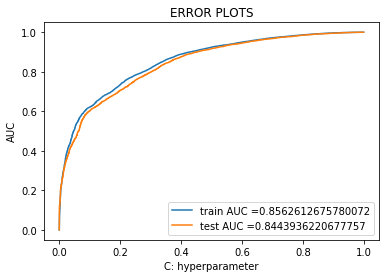

Train confusion matrix
[[ 6643  1906]
 [10728 34323]]
Test confusion matrix
[[ 2473   831]
 [ 4028 12668]]
Test AUC is: 0.5864891139052895


In [298]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


XGB = xgb.XGBClassifier(class_weight = "balanced", max_depth = 3, n_estimators = 1000) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
XGB.fit(X_train_tf_idf_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, XGB.predict_proba(X_train_tf_idf_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, XGB.predict_proba(X_test_tf_idf_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, XGB.predict(X_train_tf_idf_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, XGB.predict(X_test_tf_idf_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
XGB_tfidf_auc = roc_auc_score(Y_test, XGB.predict_proba(X_test_tf_idf_standardized)[:,1])
print("Test AUC is:", XGB_tfidf_auc)

# Confusion Matrix of Training Set Of TFIDF Model

In [300]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_train, XGB.predict(X_train_tf_idf_standardized)))
cm

array([[ 6643,  1906],
       [10728, 34323]], dtype=int64)

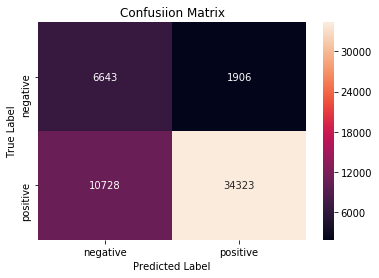

In [301]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of TFIDF Model.
1. As we have seen on confusion matrix, we have 34323 + 6643 = 40966 correct prediction on training set.
2. Acccuracy of 40966 correct prediction on training set is 76.429%.

# Confusion Matrix For Test Set Of TFIDF Model

In [302]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, XGB.predict(X_test_tf_idf_standardized)))
cm

array([[ 2473,   831],
       [ 4028, 12668]], dtype=int64)

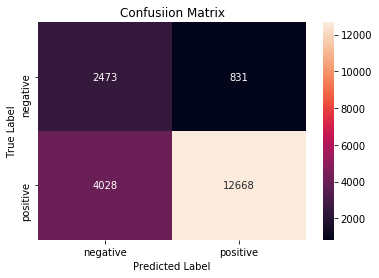

In [303]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of TFIDF Model.
2. As we have seen on confusion matrix, we have 12668 + 2473 = 15141 correct prediction on test set.
2. we have 15141 correct prediction on test set.

### Wordcloud of top 20 important features from<font color='red'> SET 2</font>

#### Top 20 important features of positive class from<font color='red'> SET 2</font>



Top 10 Important Features and their log probabilities For Positive Class :




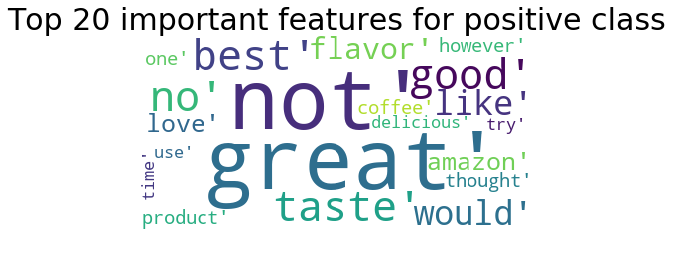

In [272]:
XGB_optimal = xgb.XGBClassifier(max_depth = optimal_depth, n_estimators = optimal_learners)

# fitting the model
XGB_optimal.fit(X_train_bow_standardized, Y_train)
# Now we can find log probabilities of different features for 'positive' classes
class_features = XGB_optimal.feature_importances_   # https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features
                                               # coef_ value is proportional to feature_log_prob_
                                               # It is like feature importance. This will give us festure importance
# 'positive' class
feature_names = pd.DataFrame(class_features.T,columns=['+ve'])

# Getting all feature names
feature_names['feature'] = count_vect.get_feature_names()

# Sorting 'positive_features' in descending order
sorted_positive_features = feature_names.sort_values(by = '+ve',kind = 'quicksort',ascending= False)
    
print("\n\nTop 10 Important Features and their log probabilities For Positive Class :\n\n")
np.array(sorted_positive_features['feature'][:20])
Positive_features = sorted_positive_features['feature'][:20]


# https://www.geeksforgeeks.org/generating-word-cloud-python/
# https://stackoverflow.com/questions/41792471/installing-wordcloud-using-jupyter-notebook
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# To install wordcloud >>>> conda install -c conda-forge wordcloud 

from wordcloud import WordCloud
wordcloud = WordCloud(collocations=False, background_color ='white', 
                min_font_size = 10).generate(str(list(Positive_features)))
plt.figure(figsize = (6, 7), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Top 20 important features for positive class",size= 30,)
plt.show()

#### Top 20 important features of negative class from<font color='red'> SET 2</font>



Top 10 Important Features and their log probabilities For Negative Class :




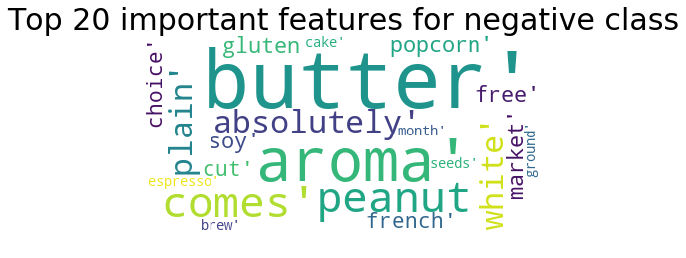

In [273]:
# Now we can find log probabilities of different features for 'negative' classes
class_features = XGB_optimal.feature_importances_   # https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features
                                               # coef_ value is proportional to feature_log_prob_
                                               # It is like feature importance. This will give us festure importance
# 'positive' class
feature_names = pd.DataFrame(class_features.T,columns=['+ve'])

# Getting all feature names
feature_names['feature'] = count_vect.get_feature_names()

# Sorting 'positive_features' in descending order
sorted_positive_features = feature_names.sort_values(by = '+ve',kind = 'quicksort',ascending= False)
    
print("\n\nTop 10 Important Features and their log probabilities For Negative Class :\n\n")
np.array(sorted_positive_features.tail(20)['feature'])

Negative_features = sorted_positive_features.tail(20)['feature']


# https://www.geeksforgeeks.org/generating-word-cloud-python/
# https://stackoverflow.com/questions/41792471/installing-wordcloud-using-jupyter-notebook
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# To install wordcloud >>>> conda install -c conda-forge wordcloud 

from wordcloud import WordCloud
wordcloud = WordCloud(collocations=False, background_color ='white', 
                min_font_size = 10).generate(str(list(Negative_features)))
plt.figure(figsize = (6, 7), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Top 20 important features for negative class",size= 30,)
plt.show()

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [274]:
# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
sent_vectors_train_standardized = sc.fit_transform(sent_vectors_train)
sent_vectors_cv_standardized = sc.fit_transform(sent_vectors_cv)
sent_vectors_test_standardized = sc.transform(sent_vectors_test)

In [275]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# tuned_parameters = [{'Depths': [[1,3,5,7,70,100,500]]}]
# or we can wright it as
Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
base_learners  = [5, 10, 50, 100, 200, 500, 1000]

param_grid = {'max_depth':Depths, 'n_estimators':base_learners}

#Using GridSearchCV
model = GridSearchCV(xgb.XGBClassifier(class_weight = "balanced"), param_grid, scoring = 'roc_auc', cv=5, n_jobs=-1, 
                     pre_dispatch=2)
model.fit(sent_vectors_cv_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(sent_vectors_cv_standardized, Y_cv))

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of depth is : ",optimal_depth)
# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)
XGB_avg_w2v_depth = optimal_depth
XGB_avg_w2v_n_estimators = optimal_learners

Model with best parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
Accuracy of the model :  0.999997735592563
The optimal value of depth is :  7
The optimal number of base learners is :  1000


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter useing seaborne heatmap

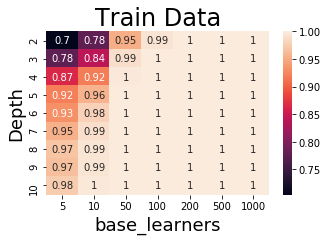

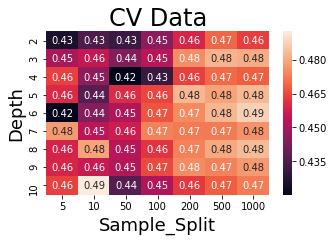

In [152]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
base_learners  = [5, 10, 50, 100, 200, 500, 1000]
hyperparameters = {'max_depth':Depths, 'n_estimators':base_learners}
for i in hyperparameters:

    XGB = xgb.XGBClassifier(class_weight = "balanced", max_depth = i, n_estimators = i)
    Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    base_learners  = [5, 10, 50, 100, 200, 500, 1000]

    param_grid = {'max_depth':Depths, 'n_estimators':base_learners}
    clf = GridSearchCV(XGB, param_grid, cv=5, scoring='roc_auc')
    clf.fit(sent_vectors_train_standardized, Y_train)


    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

df_heatmap = pd. DataFrame(train_auc. reshape(9, 7), index=Depths, columns=base_learners)
fig = plt. figure(figsize=(5, 3))
heatmap = sns. heatmap(df_heatmap, annot=True)
plt. xlabel('base_learners' , size=18)
plt. ylabel('Depth' , size=18)
plt. title("Train Data", size=24)
plt. show()

df_heatmap = pd. DataFrame(cv_auc. reshape(9, 7), index=Depths, columns=base_learners)
fig = plt. figure(figsize=(5, 3))
heatmap = sns. heatmap(df_heatmap, annot=True)
plt. xlabel('Sample_Split' , size=18)
plt. ylabel('Depth' , size=18)
plt. title("CV Data", size=24)
plt. show()

# Testing with Test data

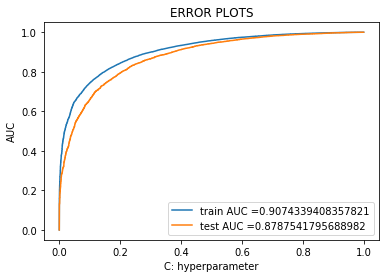

Train confusion matrix
[[ 7177  1372]
 [ 8463 36588]]
Test confusion matrix
[[ 2599   705]
 [ 3235 13461]]
Test AUC is: 0.8787541795688982


In [304]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


XGB = xgb.XGBClassifier(class_weight = "balanced", max_depth = 7, n_estimators = 1000) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
XGB.fit(sent_vectors_train_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, XGB.predict_proba(sent_vectors_train_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, XGB.predict_proba(sent_vectors_test_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, XGB.predict(sent_vectors_train_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, XGB.predict(sent_vectors_test_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
XGB_avg_w2v_auc = roc_auc_score(Y_test, XGB.predict_proba(sent_vectors_test_standardized)[:,1])
print("Test AUC is:", XGB_avg_w2v_auc)

# Confusion Matrix of Training Set Of w2v Model

In [305]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_train, XGB.predict(sent_vectors_train_standardized)))
cm

array([[ 7177,  1372],
       [ 8463, 36588]], dtype=int64)

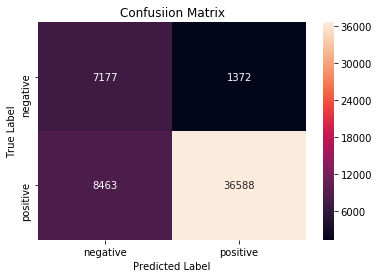

In [306]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of AVG W2V Model.
1. As we have seen on confusion matrix, we have 36588 + 7177 = 43765 correct prediction on training set.
3. Acccuracy of 43765 correct prediction on training set is 81.651%.

# Confusion Matrix For Test Set Of w2v Model

In [307]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, XGB.predict(sent_vectors_test_standardized)))
cm

array([[ 2599,   705],
       [ 3235, 13461]], dtype=int64)

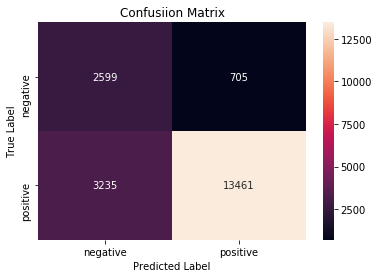

In [308]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of AVG W2V Model.
2. As we have seen on confusion matrix, we have 13461 + 2599 = 16060 correct prediction on test set.
2. we have 16060 correct prediction on test set.

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [153]:
# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
tfidf_sent_vectors_train_standardized = sc.fit_transform(tfidf_sent_vectors_train)
tfidf_sent_vectors_cv_standardized = sc.fit_transform(tfidf_sent_vectors_cv)
tfidf_sent_vectors_test_standardized = sc.transform(tfidf_sent_vectors_test)

In [154]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# tuned_parameters = [{'Depths': [[1,3,5,7,70,100,500]]}]
# or we can wright it as
Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
base_learners  = [5, 10, 50, 100, 200, 500, 1000]

param_grid = {'max_depth':Depths, 'n_estimators':base_learners}

#Using GridSearchCV
Classifier = xgb.XGBClassifier
model = GridSearchCV(xgb.XGBClassifier(class_weight = "balanced"), param_grid, scoring = 'roc_auc', cv=5, n_jobs=-1, 
                     pre_dispatch=2)
model.fit(tfidf_sent_vectors_cv_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of depth is : ",optimal_depth)
# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)
XGB_tfidf_w2v_depth = optimal_depth
XGB_tfidf_w2v_n_estimators = optimal_learners

Model with best parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
The optimal value of depth is :  3
The optimal number of base learners is :  100


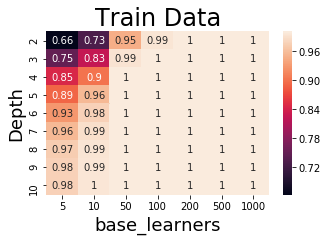

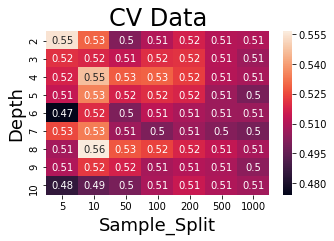

In [155]:
# Hyper parameter Tuning
# Performance of Model for each Hyperparameter useing seaborne heatmap
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
base_learners  = [5, 10, 50, 100, 200, 500, 1000]
hyperparameters = {'max_depth':Depths, 'n_estimators':base_learners}
for i in hyperparameters:

    XGB = xgb.XGBClassifier(class_weight = "balanced", max_depth = i, n_estimators = i)
    Depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    base_learners  = [5, 10, 50, 100, 200, 500, 1000]

    param_grid = {'max_depth':Depths, 'n_estimators':base_learners}
    clf = GridSearchCV(XGB, param_grid, cv=5, scoring='roc_auc')
    clf.fit(tfidf_sent_vectors_train_standardized, Y_train)


    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

df_heatmap = pd. DataFrame(train_auc. reshape(9, 7), index=Depths, columns=base_learners)
fig = plt. figure(figsize=(5, 3))
heatmap = sns. heatmap(df_heatmap, annot=True)
plt. xlabel('base_learners' , size=18)
plt. ylabel('Depth' , size=18)
plt. title("Train Data", size=24)
plt. show()

df_heatmap = pd. DataFrame(cv_auc. reshape(9, 7), index=Depths, columns=base_learners)
fig = plt. figure(figsize=(5, 3))
heatmap = sns. heatmap(df_heatmap, annot=True)
plt. xlabel('Sample_Split' , size=18)
plt. ylabel('Depth' , size=18)
plt. title("CV Data", size=24)
plt. show()

# Testing with Test data

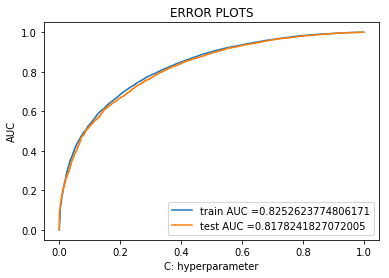

Train confusion matrix
[[ 6399  2150]
 [11747 33304]]
Test confusion matrix
[[ 2427   877]
 [ 4403 12293]]
Test AUC is: 0.8483284914917784


In [309]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


XGB = xgb.XGBClassifier(class_weight = "balanced", max_depth = 3, n_estimators = 1000) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
XGB.fit(tfidf_sent_vectors_train_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, XGB.predict_proba(tfidf_sent_vectors_train_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, XGB.predict_proba(tfidf_sent_vectors_test_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, XGB.predict(tfidf_sent_vectors_train_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, XGB.predict(tfidf_sent_vectors_test_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
XGB_tfidf_w2v_auc = roc_auc_score(Y_test, XGB.predict_proba(tfidf_sent_vectors_test_standardized)[:,1])
print("Test AUC is:", XGB_tfidf_w2v_auc)

# Confusion Matrix of Training Set Of TFIDF W2V Model

In [313]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_train, XGB.predict(tfidf_sent_vectors_train_standardized)))
cm

array([[ 6399,  2150],
       [11747, 33304]], dtype=int64)

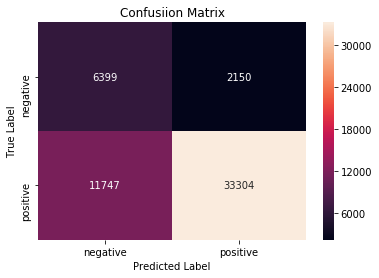

In [314]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of TFIDF W2V Model.
1. As we have seen on confusion matrix, we have 33304 + 6399 = 39703 correct prediction on training set.
3. Acccuracy of 39703 correct prediction on training set is 74.072%.

# Confusion Matrix For Test Set Of TFIDF W2V Model

In [315]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, XGB.predict(tfidf_sent_vectors_test_standardized)))
cm

array([[ 2427,   877],
       [ 4403, 12293]], dtype=int64)

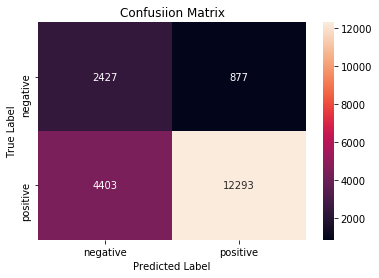

In [316]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of TFIDF W2V Model.
2. As we have seen on confusion matrix, we have 12293 + 2427 = 14720 correct prediction on test set.
2. we have 14720 correct prediction on test set.

# [6] Conclusions

# Observation table for Random Forests

In [319]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of the models
names =['Random Forest for BoW','Random Forest for TFIDF','Random Forest for Avg_Word2Vec','Random Forest for tfidf_Word2Vec']

# Values of optimal depth
optimal_depth = [RF_bow_depth, RF_tfidf_depth, RF_avg_w2v_depth, RF_tfidf_w2v_depth]

# Values of optimal n_estimators
optimal_n_estimators = [RF_bow_n_estimators, RF_tfidf_n_estimators, RF_avg_w2v_n_estimators, RF_tfidf_n_estimators]

#AUC
AUC = [RF_bow_auc, RF_tfidf_auc, RF_avg_w2v_auc, RF_tfidf_w2v_auc]

numbering = [1,2,3,4]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Optimal Depth",optimal_depth)
ptable.add_column("optimal_n_estimators",optimal_n_estimators)
ptable.add_column("AUC",AUC)

# Printing the Table
print(ptable)

+-------+----------------------------------+---------------+----------------------+--------------------+
| S.NO. |              MODEL               | Optimal Depth | optimal_n_estimators |        AUC         |
+-------+----------------------------------+---------------+----------------------+--------------------+
|   1   |      Random Forest for BoW       |       10      |         1000         | 0.8622059164973763 |
|   2   |     Random Forest for TFIDF      |       7       |         1000         | 0.8656524837109931 |
|   3   |  Random Forest for Avg_Word2Vec  |       7       |         1000         | 0.8789206118297173 |
|   4   | Random Forest for tfidf_Word2Vec |       10      |         1000         | 0.8629857153588861 |
+-------+----------------------------------+---------------+----------------------+--------------------+


# Observation table for GBDT

# Table for Gradient Boosting Decision Tree (GBDT)

In [321]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of the models
names =['GBDT for BoW','GBDT for TFIDF','GBDT for Avg_Word2Vec','GBDT for tfidf_Word2Vec']

# Values of optimal depth
optimal_depth = [XGB_bow_depth, XGB_tfidf_depth, XGB_avg_w2v_depth, XGB_tfidf_w2v_depth]

# Values of optimal n_estimators
optimal_n_estimators = [XGB_bow_n_estimators, XGB_tfidf_n_estimators, XGB_avg_w2v_n_estimators, XGB_tfidf_n_estimators]

#AUC
AUC = [XGB_bow_auc, XGB_tfidf_auc, XGB_avg_w2v_auc, XGB_tfidf_w2v_auc]

numbering = [1,2,3,4]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Optimal Depth",optimal_depth)
ptable.add_column("optimal_n_estimators",optimal_n_estimators)
ptable.add_column("AUC",AUC)

# Printing the Table
print(ptable)

+-------+-------------------------+---------------+----------------------+--------------------+
| S.NO. |          MODEL          | Optimal Depth | optimal_n_estimators |        AUC         |
+-------+-------------------------+---------------+----------------------+--------------------+
|   1   |       GBDT for BoW      |       3       |         1000         | 0.8411564139849941 |
|   2   |      GBDT for TFIDF     |       3       |         1000         | 0.5864891139052895 |
|   3   |  GBDT for Avg_Word2Vec  |       7       |         1000         | 0.8787541795688982 |
|   4   | GBDT for tfidf_Word2Vec |       3       |         1000         | 0.8483284914917784 |
+-------+-------------------------+---------------+----------------------+--------------------+


# Procedure Followed:

STEP 1 : Loading The Data
    
STEP 2 : Data Cleaning: Deduplication

STEP 3 : Preprocessing Review Text

STEP 4 : Preprocessing Review Summary

STEP 5 : Time-based splitting of whole dataset into X_train, Y_train, X_test, Y_test, X_cv and Y_cv.

STEP 6 : Applying Featurization Technique to convert text into vector.(i.e. BAG OF WORDS Model)

STEP 7 : Standardizing the data
    
STEP 8 : Applying Random Forest on BOW
        
STEP 9:  Using Random Forest as an estimator in GridSearchCV in order to find optimal value of depth 
         and optimal value of n_estimators of the tree

STEP 10 : Plotting the performance of model both on train data and cross validation data for each hyper parameter
          (with seaborn heatmaps)

STEP 11 : Finding the AUC on test data and plotting the ROC curve on both train and test.

STEP 12 : Drawing the confusion matrix using Seaborn Heatmaps.

STEP 13 : Finding the top 20 features of positive class with word count from Set 1. (Only in Bow and TFIDF Vectorizer)

STEP 14 : Finding top 20 features of negative class with word count from Set 1.(Only in Bow and TFIDF Vectorizer)
    
STEP 15 : Repeat STEP 6 to STEP 14 for TFIDF, Avg_w2v, TFIDF_w2v Vectorizer.
    
STEP 16 : Standardizing the data
    
STEP 17 : Applying XG Boost on BOW
        
STEP 18:  Using XG Boost as an estimator in GridSearchCV in order to find optimal value of depth 
         and optimal value of n_estimators.

STEP 19 : Plotting the performance of model both on train data and cross validation data for each hyper parameter
          (with seaborn heatmaps)

STEP 20 : Finding the AUC on test data and plotting the ROC curve on both train and test.

STEP 21 : Drawing the confusion matrix using Seaborn Heatmaps.

STEP 22 : Finding the top 20 features of positive class with word count from Set 1. (Only in Bow and TFIDF Vectorizer)

STEP 23 : Finding top 20 features of negative class with word count from Set 1.(Only in Bow and TFIDF Vectorizer)
    
STEP 24 : Repeat STEP 16 to STEP 23 for TFIDF, Avg_w2v, TFIDF_w2v Vectorizer.